In [1]:
%matplotlib inline

import os
import re
import random
import numpy as np
import cv2
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

### Training Data
I collected different training sets and stored them in different folders.
- data_base are the samples from Udacity
- data_curves contains curve only samples
- data_recovery contains samples from recovery
- data_smooth_jungle contains samples where I tried to stay on track
- data_smooth_lake contains samples where I tried to stay on track
- data_straightahead

In [36]:
# Only data_base contains a header. So add a header to the other ones when they are
# read into data frames
header = ["center","left", "right", "steering", "throttle", "brake", "speed"]

data_base = './data_base/driving_log.csv'
data_curves ='./data_curves/driving_log.csv'
data_recovery = './data_recovery/driving_log.csv'
data_smooth_jungle = './data_smooth_jungle/driving_log.csv'
data_smooth_lake = './data_smooth_lake/driving_log.csv'
data_straightahead = './data_straightahead/driving_log.csv'

df_data_base = pd.read_csv(data_base)
df_data_curves = pd.read_csv(data_curves, names=header)
df_data_recovery = pd.read_csv(data_recovery, names=header)
df_data_smooth_jungle = pd.read_csv(data_smooth_jungle, names=header)
df_data_smooth_lake = pd.read_csv(data_smooth_lake, names=header)
df_data_straightahead = pd.read_csv(data_straightahead, names=header)

df_collected_data = df_data_curves.append(df_data_recovery).append(df_data_smooth_jungle).append(df_data_smooth_lake).append(df_data_straightahead)

print("Samples data_base {}".format(len(df_data_base)))
print("Samples data_curves {}".format(len(df_data_curves)))
print("Samples data_recovery {}".format(len(df_data_recovery)))
print("Samples data_smooth_jungle {}".format(len(df_data_smooth_jungle)))
print("Samples data_smooth_lake {}".format(len(df_data_smooth_lake)))
print("Samples data_straightahead {}".format(len(df_data_straightahead)))


print("Samples data_all {}".format(len(df_collected_data)))

df_all_with_base = df_data_base.append(df_data_all)
print("Samples data_all_all {}".format(len(df_data_all)))

Samples data_base 8036
Samples data_curves 14619
Samples data_recovery 3404
Samples data_smooth_jungle 12675
Samples data_smooth_lake 7190
Samples data_straightahead 708
Samples data_all 38596
Samples data_all_all 46632


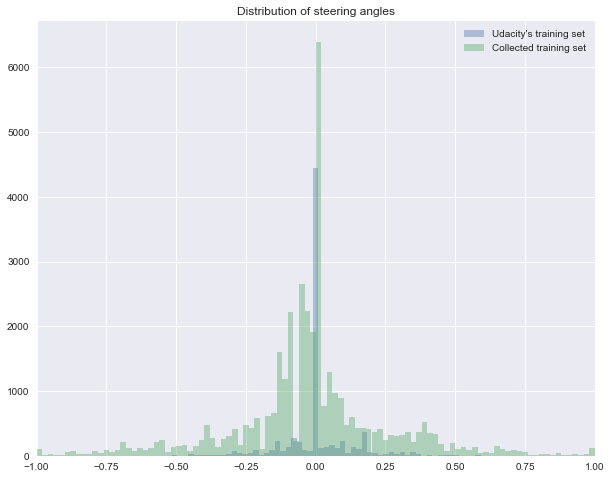

In [35]:
plt.rcParams['figure.figsize'] = (10, 8)

fig, ax = plt.subplots()
ax.set_title("Distribution of steering angles")

sns.distplot(df_data_base[[3]], bins=100, ax=ax, kde=False, label="Udacity's training set")
sns.distplot(df_collected_data[[3]], bins=100, ax=ax, kde=False, label="Collected training set")

ax.set_xlim([-1.0, 1.0])
ax.legend()

In [37]:
def show_camera_images(left, center, right):
    """
    Display three images in a row.
    """
    plt.rcParams['figure.figsize'] = (20, 10)
    fig = plt.figure()

    ax = fig.add_subplot(1, 3, 1)
    ax.grid(False)
    ax.imshow(left)
    ax.set_title("Left Camera")

    ax = fig.add_subplot(1, 3, 2)
    ax.grid(False)
    ax.imshow(center)
    ax.set_title("Center Camera")

    ax = fig.add_subplot(1, 3, 3)
    ax.grid(False)
    ax.imshow(right)
    ax.set_title("Right Camera")


In [38]:
def crop_image(image, x, wx, y, hy):
    return image[y:hy, x:wx]

def contrast(image, cfactor=0.5):

    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    img_yuv[:,:,0] =  np.where(img_yuv[:,:,0] * cfactor < 255, img_yuv[:,:,0] * cfactor, 255) 
           
    # convert the YUV image back to RGB format
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def grayscale(image):
    """
    Converts an image to grayscale and reshapes it to (32,32,1)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def rotate(img, d):
    """
    Rotates an image for d degrees
    @d degrees
    """ 
    rows,cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2), d, 1)
    
    return cv2.warpAffine(img,M,(cols,rows))

def shift_horizontal(img, angle):
    """
    Shifts an image in horizontal direction.
    @image  The image to be shifted.
    @angle  Original steering angle which is updated.
    """
    # Linear equation is used to calculate the offset that shall
    # be added to the original angle.
    # offset = k * shiftx + d
    k = 0.005
    
    shiftx = random.randint(-50, 50)
    angle_new = k * shiftx + angle
    
    print("Shiftx {}, new angle {}, old angle {}".format(shiftx, angle_new, angle))
    
    rows,cols = img.shape[:2]  
    M = np.float32([[1, 0, shiftx], [0, 1, 0]])
    
    return cv2.warpAffine(img, M, (cols,rows))

def flip_image(image, steering_angle):
    image_flipped = np.fliplr(image)
    steering_angle_flipped = -steering_angle
    
    return image_flipped, steering_angle_flipped

In [39]:
def get_relative_path(base_dir, full_path):
    tokens = re.split('[\\,\\\\,/]', full_path )
    path = os.path.join(base_dir, 'IMG')
    path = os.path.join(path, tokens[-1])
    
    return path

def explore_data(base_dir):
    df = read_data(os.path.join(base_dir,'driving_log.csv'))

    #plot_histogram(df)
    
    # Lets have a look at center, left and right image
    left = np.asarray(Image.open(get_relative_path(base_dir, df.iat[0,1])))
    center = np.asarray(Image.open(get_relative_path(base_dir, df.iat[0,0])))
    right = np.asarray(Image.open(get_relative_path(base_dir, df.iat[0,2])))

    # show steering value
    angle = df.iat[0,3]
    print("steering angle: {}".format(angle))
    show_camera_images(left, center, right)
    
    # crop images
    x = 0
    wx = x + 320
    y = 70
    hy = y + 65
    center_cropped = crop_image(center, x, wx, y, hy)
    
    # Change contrast
    print ("change contrast")
    center_contrasted = contrast(center_cropped, 0.4)
    center_contrasted2 = contrast(center_cropped, 1.2)
    center_contrasted3 = contrast(center_cropped,0.2)
    show_camera_images(center_contrasted, center_contrasted2, center_contrasted3)
    
    print ("shifting image")
    shift_center_img1 = shift_horizontal(center_cropped, df.iat[0,3])
    shift_center_img2 = shift_horizontal(center_cropped, df.iat[0,3])
    show_camera_images(shift_center_img1, center_cropped, shift_center_img2)
    
    print("grayscaling images")
    gray_center1 = grayscale( center_contrasted )
    gray_center = grayscale(center_contrasted2)
    gray_center2 = grayscale( center_contrasted3 )
    show_camera_images(gray_center1, gray_center, gray_center2)
        
    print("flipping images")
    flipped_center1, _ = flip_image( gray_center1, angle )
    flipped_center, _  = flip_image( gray_center, angle)
    flipped_center2, _ = flip_image( gray_center2, angle )
    show_camera_images(flipped_center1, flipped_center, flipped_center2)
    

steering angle: -0.11885739999999999
change contrast
shifting image
Shiftx 38, new angle 0.07114260000000001, old angle -0.11885739999999999
Shiftx 14, new angle -0.04885739999999998, old angle -0.11885739999999999
grayscaling images
flipping images


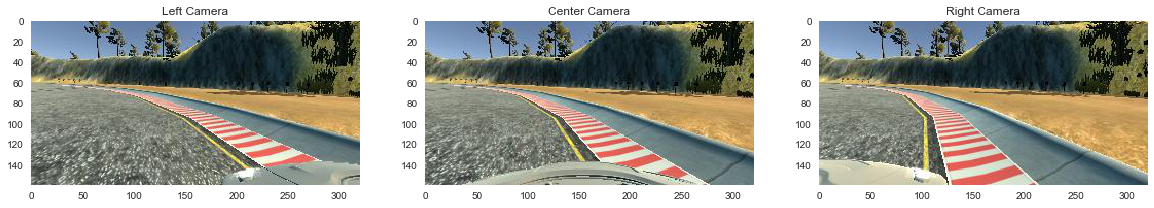

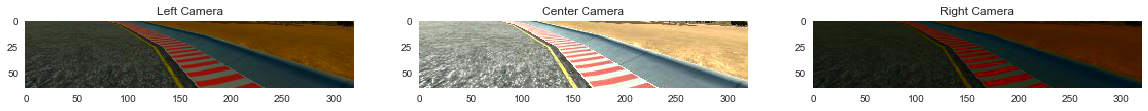

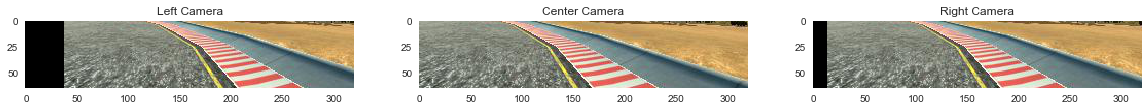

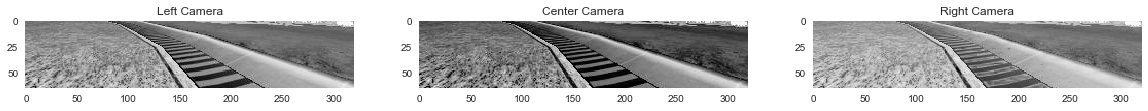

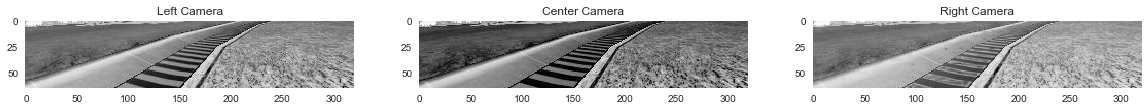

In [40]:
#explore_data('data_straightahead')
#explore_data('data_curves')
explore_data('data_recovery')

### Data Augmentation
In the next cells we will augment our data. The following methods will be applied to the available images.
- Image flipping
- Adding an artifical shadow